ARIMA Model – Time Series Forecasting

Using ARIMA model (AutoRegressive Integrated Moving Average), you can forecast a time series using the series past values (examining a past value's own lags and the lagged forecast errors). Specifically, ‘Auto Regressive’ means ARIMA is a linear regression model that uses its own lags as predictors. In this post, we build an optimal ARIMA model from scratch and extend it to Seasonal ARIMA (SARIMA) and SARIMAX models.

Source: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

Here, Univariate Time Series Forecasting was employed because we used only the previous values of the time series to predict its future values.

ARIMA model is characterized by 3 terms: p, d, q

p = Order of the ‘Auto Regressive’ (AR) term which refers to the number of lags of Y to be used as predictors. 

q = Order of the ‘Moving Average’ (MA) term which refers to the number of lagged forecast errors that should go into the ARIMA Model.

d = Number of differencing required to make the time series stationary. To make a series stationary, we difference it or subtract the previous value from the current value. The value of d, therefore, is the minimum number of differencing needed to make the series stationary (if the time series is already stationary, then d = 0).

NOTE: When using predictors other than the series (a.k.a exogenous variables) to forecast, employ Multi Variate Time Series Forecasting.

In [1]:
# Modules
import os

# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# Use numpy to convert to arrays
import numpy as np

from scipy.stats import sem

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Import the model we are using
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

In [2]:
# STEP 1: Finding the order of differencing

from statsmodels.tsa.stattools import adfuller
from numpy import log

In [3]:
# Load the "US_emissions_by_gas_1990-2017_data.xlsx" Dataset

US_gas_data = pd.read_excel("data/US_emissions_by_gas_1990_2017_data.xlsx")
US_gas_data.head()

,Year,Carbon_dioxide,Methane,Nitrous_oxide,Fluorinated_gases,Total
0,1990,5121.179440,779.845550,370.307694,99.667859,6371.000543
1,1991,5071.563914,784.384856,368.961757,90.704668,6315.615194
2,1992,5174.670601,783.176602,371.786442,95.300712,6424.934357
3,1993,5281.386608,770.308404,385.347234,95.027350,6532.069596
4,1994,5375.033803,775.160651,376.511527,98.129806,6624.835787


In [4]:
# Check if the Carbon_dioxide series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
CO2_result = adfuller(US_gas_data.Carbon_dioxide.dropna())
print('ADF Statistic: %f' % CO2_result[0])
print('p-value: %f' % CO2_result[1])

ADF Statistic: -3.038130
p-value: 0.031484


RULE: The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

If,

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

So, since p-value: 0.031484, then the null hypothesis (H0) is rejected; and the data does not have a unit root and is stationary!  HOWEVER, we will see later in the CO2 graph, we can't rely on this p-value.

A model with no orders of differencing assumes that the original series is stationary (mean-reverting).

In [5]:
# Check if the Methane series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
methane_result = adfuller(US_gas_data.Methane.dropna())
print('ADF Statistic: %f' % methane_result[0])
print('p-value: %f' % methane_result[1])

ADF Statistic: -1.003607
p-value: 0.751947


In [6]:
# Check if the Nitrous_oxide series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
NO_result = adfuller(US_gas_data.Nitrous_oxide.dropna())
print('ADF Statistic: %f' % NO_result[0])
print('p-value: %f' % NO_result[1])

ADF Statistic: -3.010076
p-value: 0.033964


So, since p-value: 0.033964, then the null hypothesis (H0) is rejected; and the data does not have a unit root and is stationary!

In [7]:
# Check if the Fluorinated_gases series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
Fluro_result = adfuller(US_gas_data.Fluorinated_gases.dropna())
print('ADF Statistic: %f' % Fluro_result[0])
print('p-value: %f' % Fluro_result[1])

ADF Statistic: -0.591758
p-value: 0.872834


In [8]:
# Check if the Total series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
total_result = adfuller(US_gas_data.Total.dropna())
print('ADF Statistic: %f' % total_result[0])
print('p-value: %f' % total_result[1])

ADF Statistic: -2.660969
p-value: 0.081039


Since the p-values of Methane, Fluorinated gases and Total were not less than 0.05 and greater than the significance level, differencing the series is necessary.

A model with one order of differencing assumes that the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth).

Below is the autocorrelation plots for all of the gases. We're checking the autocorrelation plot for CO2 and we'll find that there is indeed a trend (not stationary).  

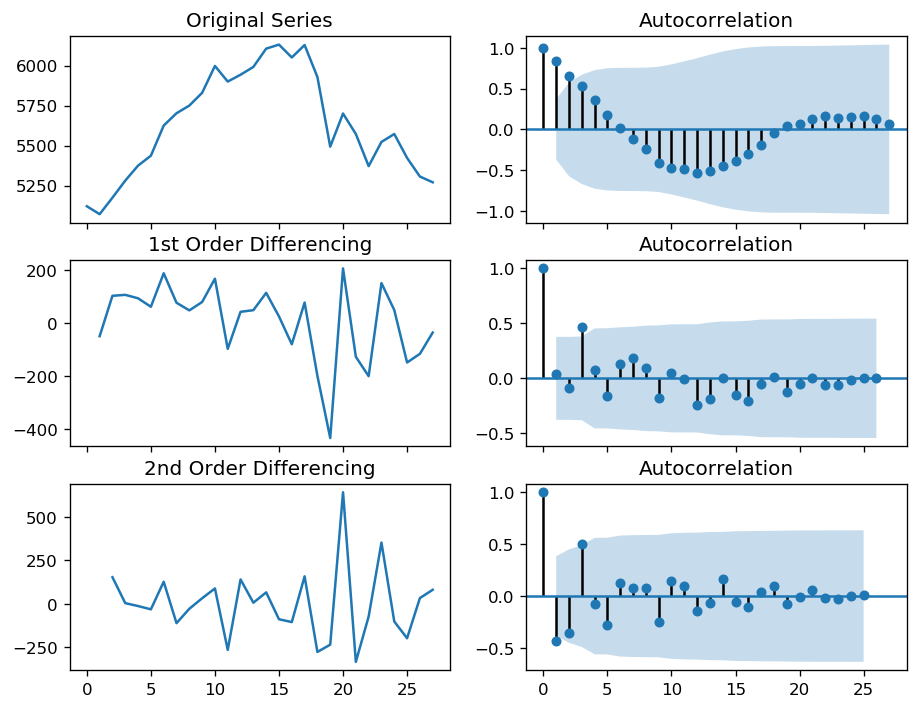

In [9]:
## Autocorrelation plots for Carbon_dioxide series.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(US_gas_data[0:28].Carbon_dioxide); axes[0, 0].set_title('Original Series')
plot_acf(US_gas_data[0:28].Carbon_dioxide, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(US_gas_data[0:28].Carbon_dioxide.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(US_gas_data[0:28].Carbon_dioxide.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(US_gas_data[0:28].Carbon_dioxide.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(US_gas_data[0:28].Carbon_dioxide.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

There's a clear up trend and then down trend in the CO2 original series. With this, it's best to split the data to examine the autocorrelation plots separately.

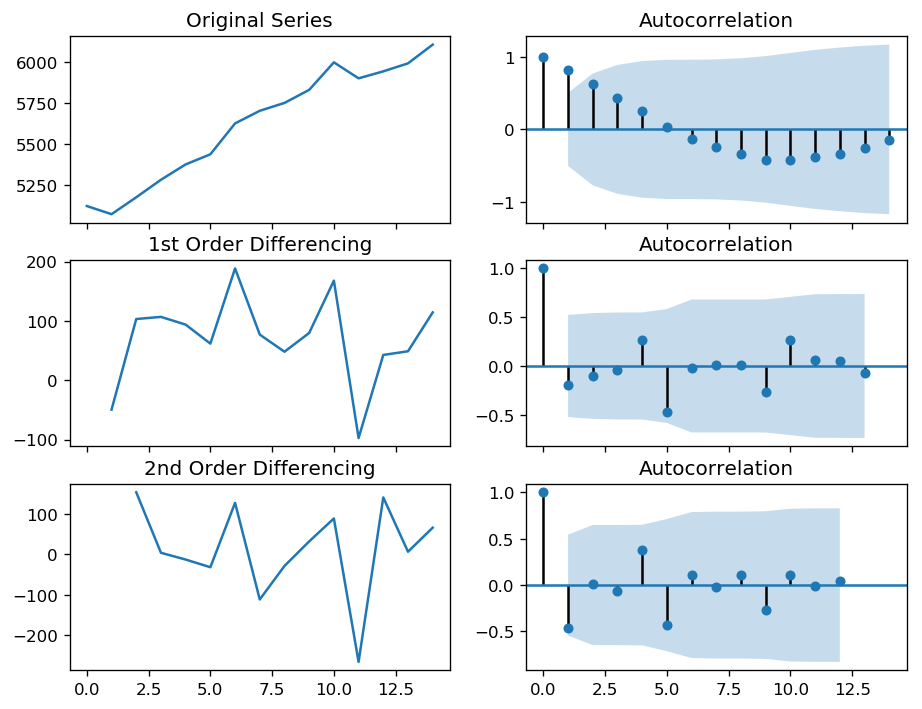

In [10]:
# Carbon_dioxide 1990-2004 Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(US_gas_data[0:15].Carbon_dioxide); axes[0, 0].set_title('Original Series')
plot_acf(US_gas_data[0:15].Carbon_dioxide, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(US_gas_data[0:15].Carbon_dioxide.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(US_gas_data[0:15].Carbon_dioxide.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(US_gas_data[0:15].Carbon_dioxide.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(US_gas_data[0:15].Carbon_dioxide.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [11]:
# Recheck Carbon_dioxide 1990-2004 series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
CO2_uptrend = adfuller(US_gas_data[0:15].Carbon_dioxide.dropna())
print('ADF Statistic: %f' % CO2_uptrend[0])
print('p-value: %f' % CO2_uptrend[1])

ADF Statistic: 0.000000
p-value: 0.958532


/Users/annieylai/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [12]:
# Carbon_dioxide 1990-2004 series 1st order differencing.
CO2_uptrend_1diff = adfuller(US_gas_data[15:].Carbon_dioxide.diff().dropna())
print('ADF Statistic: %f' % CO2_uptrend_1diff[0])
print('p-value: %f' % CO2_uptrend_1diff[1])

ADF Statistic: -0.000000
p-value: 0.958532


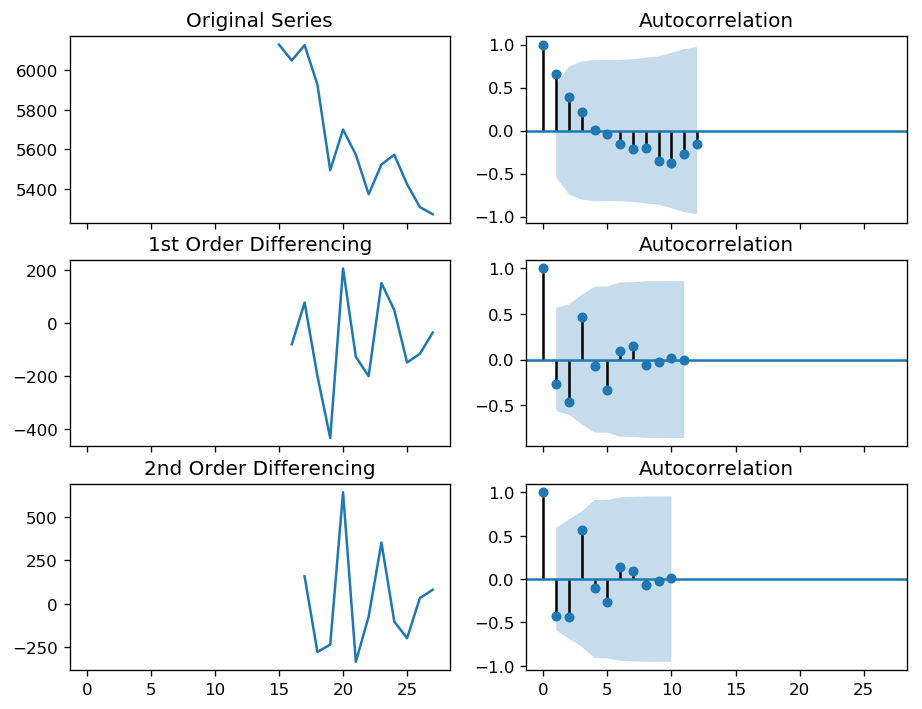

In [13]:
# Carbon_dioxide 2004-2017 Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(US_gas_data[15:].Carbon_dioxide); axes[0, 0].set_title('Original Series')
plot_acf(US_gas_data[15:].Carbon_dioxide, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(US_gas_data[15:].Carbon_dioxide.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(US_gas_data[15:].Carbon_dioxide.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(US_gas_data[15:].Carbon_dioxide.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(US_gas_data[15:].Carbon_dioxide.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [14]:
# Recheck Carbon_dioxide 2004-2017 series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
CO2_downtrend = adfuller(US_gas_data[15:].Carbon_dioxide.dropna())
print('ADF Statistic: %f' % CO2_downtrend[0])
print('p-value: %f' % CO2_downtrend[1])

ADF Statistic: -2.471985
p-value: 0.122440


In [15]:
# Carbon_dioxide 2004-2017 series 1st order differencing.

CO2_downtrend_1diff = adfuller(US_gas_data[15:].Carbon_dioxide.diff().dropna())
print('ADF Statistic: %f' % CO2_downtrend_1diff[0])
print('p-value: %f' % CO2_downtrend_1diff[1])

ADF Statistic: -0.000000
p-value: 0.958532


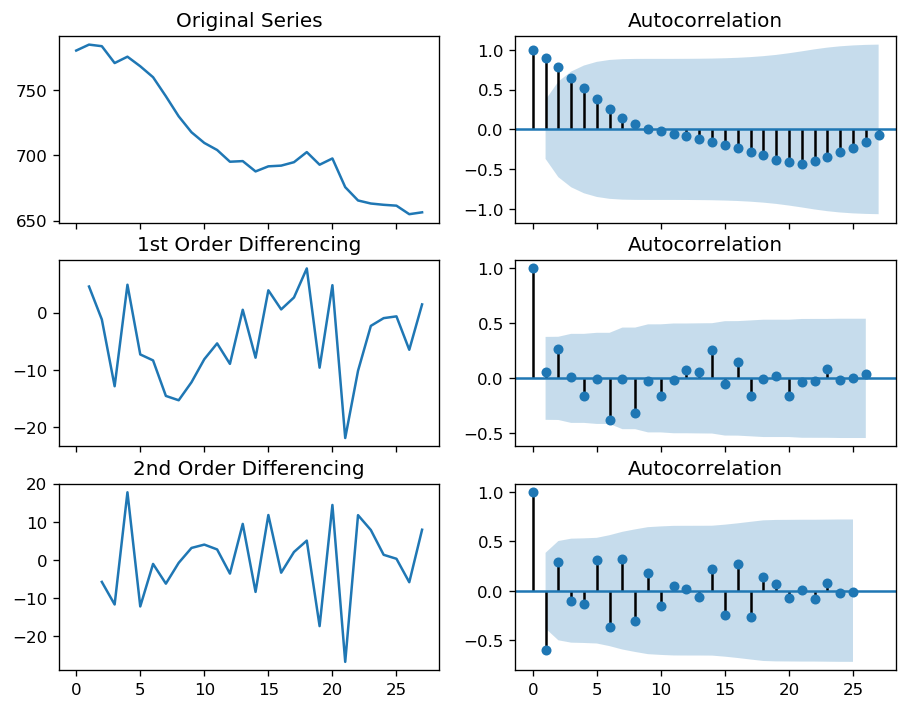

In [16]:
## Differencing Methane series.

import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(US_gas_data.Methane); axes[0, 0].set_title('Original Series')
plot_acf(US_gas_data.Methane, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(US_gas_data.Methane.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(US_gas_data.Methane.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(US_gas_data.Methane.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(US_gas_data.Methane.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [17]:
# Methane series 1st order differencing.

methane_1diff = adfuller(US_gas_data.Methane.diff().dropna())
print('ADF Statistic: %f' % methane_1diff[0])
print('p-value: %f' % methane_1diff[1])

ADF Statistic: -4.692242
p-value: 0.000087


p-value of Methane is now <0.05, now stationary, at 1 order of differencing!

NOTE: In the 1st order differencing autocorrelation plot, the lag goes near zero fairly quick (good). In the 2nd order differencing autocorrelation plot, the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced. The subsequent lags in the 1st order differencing autocorrelation plot are tight to the zero line (good), whereas in the 2nd order differencing autocorrelation plot the subsequent lags are farther from the zero line (less ideal).

Below is the autocorrelation plot for Nitrous_oxide.

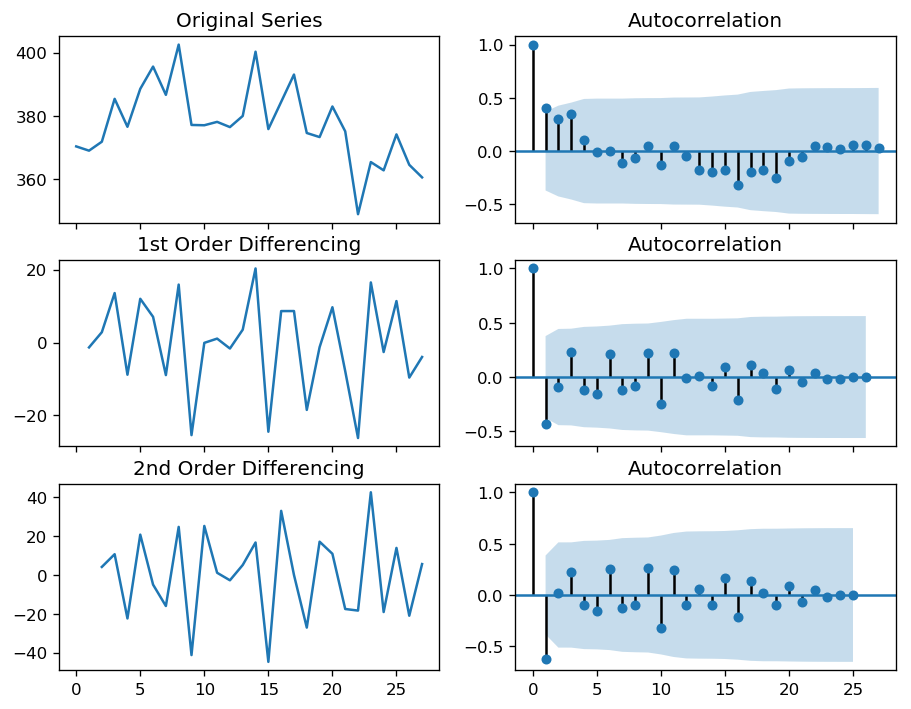

In [18]:
## Differencing Nitrous_oxide series.

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(US_gas_data.Nitrous_oxide); axes[0, 0].set_title('Original Series')
plot_acf(US_gas_data.Nitrous_oxide, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(US_gas_data.Nitrous_oxide.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(US_gas_data.Nitrous_oxide.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(US_gas_data.Nitrous_oxide.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(US_gas_data.Nitrous_oxide.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [19]:
# Nitrous_oxide series 1st order differencing.

Nitrous_oxide_1diff = adfuller(US_gas_data.Nitrous_oxide.diff().dropna())
print('ADF Statistic: %f' % Nitrous_oxide_1diff[0])
print('p-value: %f' % Nitrous_oxide_1diff[1])

ADF Statistic: -5.683960
p-value: 0.000001


NOTE: The 1st order autocorrelation plot indicates that 1st order differencing is over differenced. 

Below is the autocorrelation plot for Fluorinated_gases.

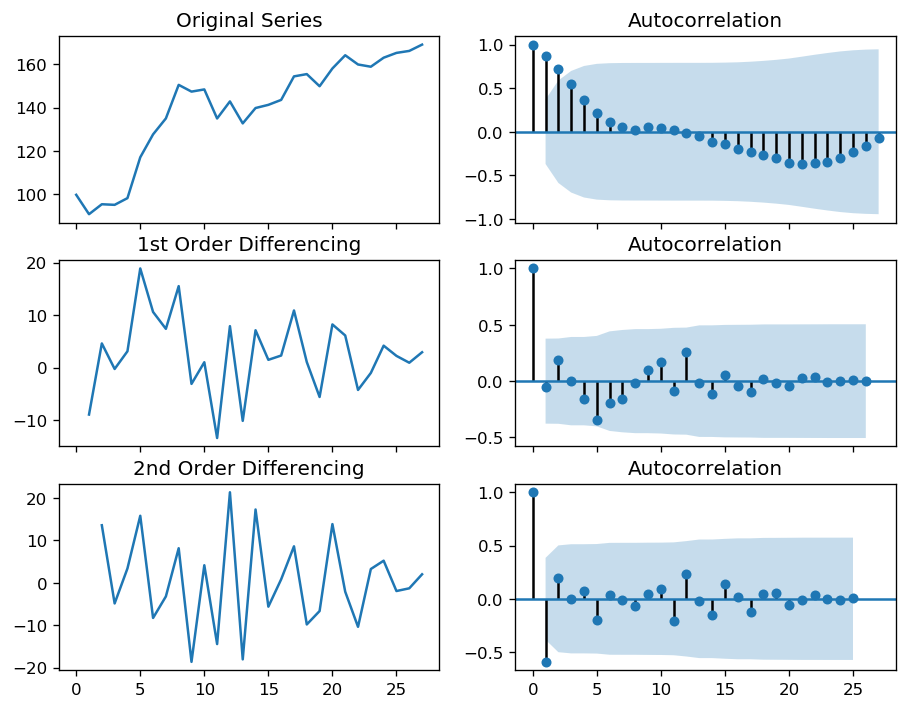

In [20]:
## Differencing Fluorinated_gases series.

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(US_gas_data.Fluorinated_gases); axes[0, 0].set_title('Original Series')
plot_acf(US_gas_data.Fluorinated_gases, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(US_gas_data.Fluorinated_gases.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(US_gas_data.Fluorinated_gases.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(US_gas_data.Fluorinated_gases.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(US_gas_data.Fluorinated_gases.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [21]:
# Fluorinated_gases series 1st order differencing.

fluorinated_1diff = adfuller(US_gas_data.Fluorinated_gases.diff().dropna())
print('ADF Statistic: %f' % fluorinated_1diff[0])
print('p-value: %f' % fluorinated_1diff[1])

ADF Statistic: -3.075023
p-value: 0.028458


p-value of Fluorinated_gases is now <0.05, now stationary, at 1 order of differencing!

Below is the autocorrelation plot for Total.

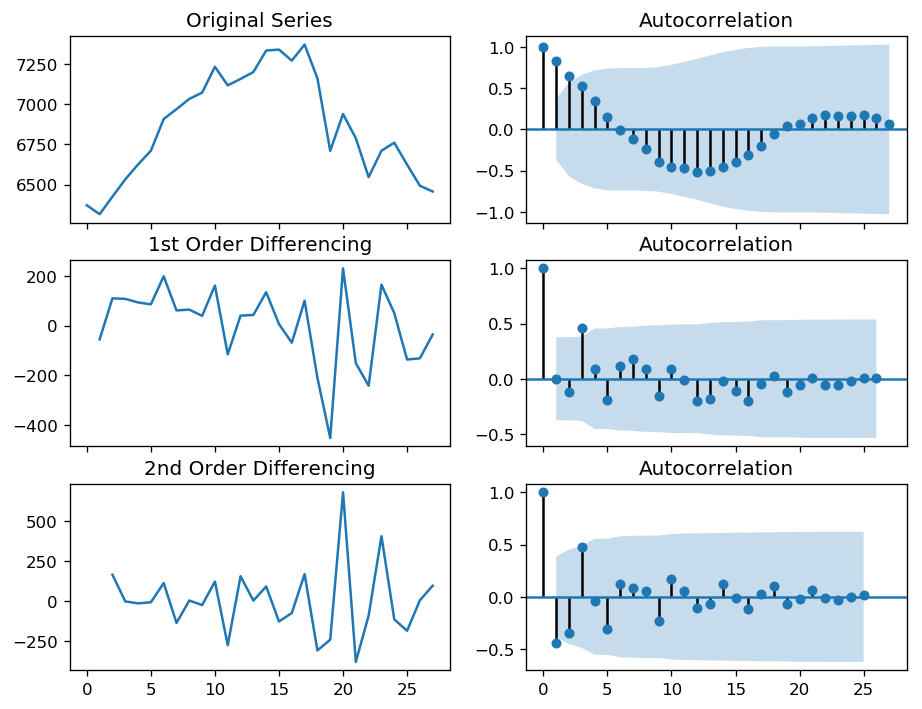

In [22]:
## Differencing Total series.

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(US_gas_data.Total); axes[0, 0].set_title('Original Series')
plot_acf(US_gas_data.Total, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(US_gas_data.Total.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(US_gas_data.Total.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(US_gas_data.Total.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(US_gas_data.Total.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [23]:
# Total series 1st order differencing.

total_1diff = adfuller(US_gas_data.Total.diff().dropna())
print('ADF Statistic: %f' % total_1diff[0])
print('p-value: %f' % total_1diff[1])

ADF Statistic: -1.328912
p-value: 0.615843


In [24]:
# Total series 2nd order differencing.

total_2diff = adfuller(US_gas_data.Total.diff().diff().dropna())
print('ADF Statistic: %f' % total_2diff[0])
print('p-value: %f' % total_2diff[1])

ADF Statistic: -1.232187
p-value: 0.659599


NOTE: The Total series is heavily dependent on the CO2 series. Thus, similar to the CO2 plots, total should be split. 

STEP 2: Find the order of the AR term (p). Inspect the Partial Autocorrelation (PACF), or the correlation between the series and its lag, to determine if a particular lag is needed in the AR term for pure correlation. 

/Users/annieylai/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


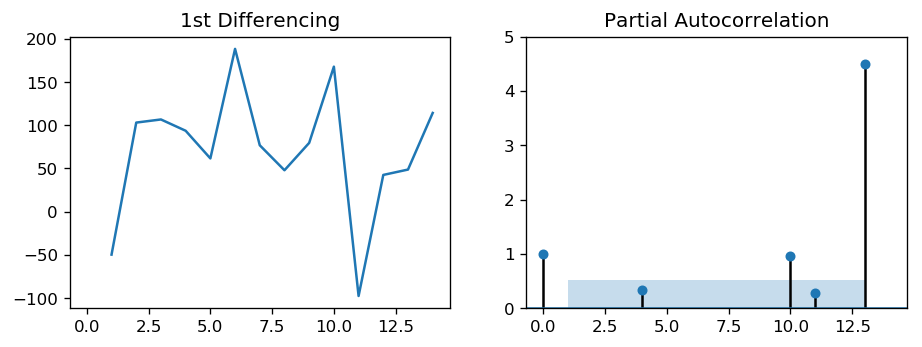

In [25]:
# Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. 
# So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

# PACF plot of 1st differenced Carbon dioxide 1990-2005 series

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data[0:15].Carbon_dioxide.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(US_gas_data[0:15].Carbon_dioxide.diff().dropna(), ax=axes[1])

plt.show()

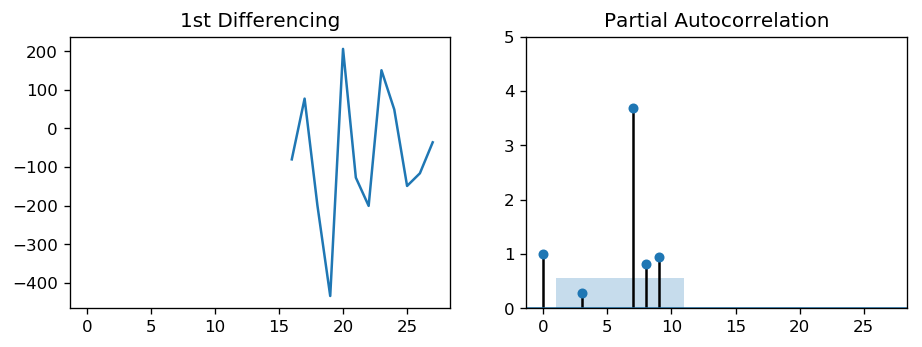

In [26]:
# PACF plot of 1st differenced Carbon dioxide 2005-2017 series

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data[15:].Carbon_dioxide.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(US_gas_data[15:].Carbon_dioxide.diff().dropna(), ax=axes[1])

plt.show()

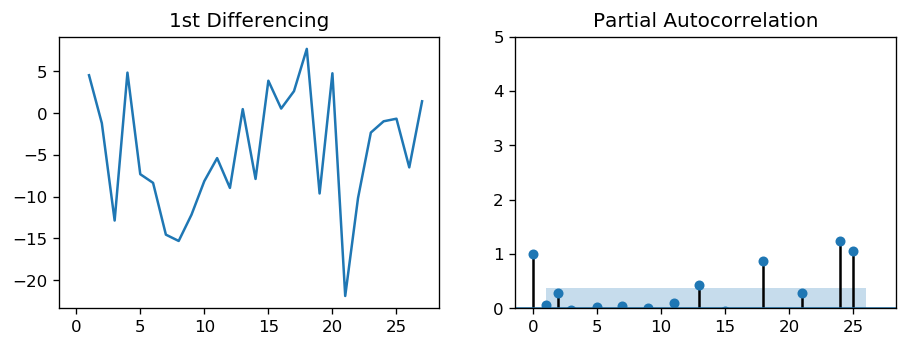

In [27]:
# PACF plot of 1st differenced Methane series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data.Methane.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(US_gas_data.Methane.diff().dropna(), ax=axes[1])

plt.show()

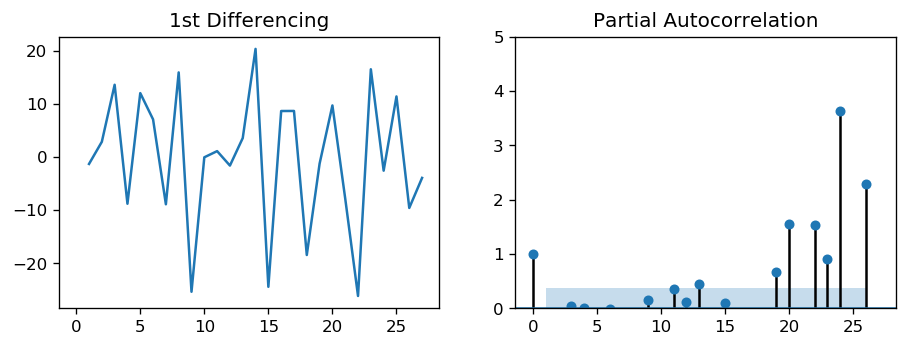

In [28]:
# PACF plot of 1st differenced Nitrous_oxide series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data.Nitrous_oxide.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(US_gas_data.Nitrous_oxide.diff().dropna(), ax=axes[1])

plt.show()

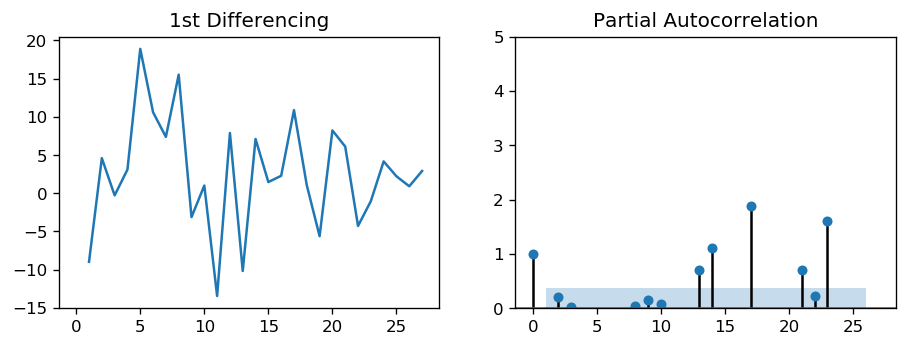

In [29]:
# PACF plot of 1st differenced Fluorinated_gases series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data.Fluorinated_gases.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(US_gas_data.Fluorinated_gases.diff().dropna(), ax=axes[1])

plt.show()

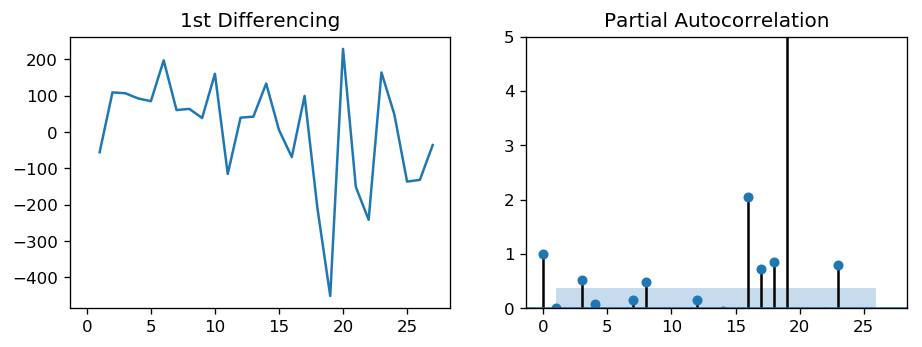

In [30]:
# PACF plot of 1st differenced Total series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data.Total.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(US_gas_data.Total.diff().dropna(), ax=axes[1])

plt.show()

STEP 3: Find the order of the MA term (q).

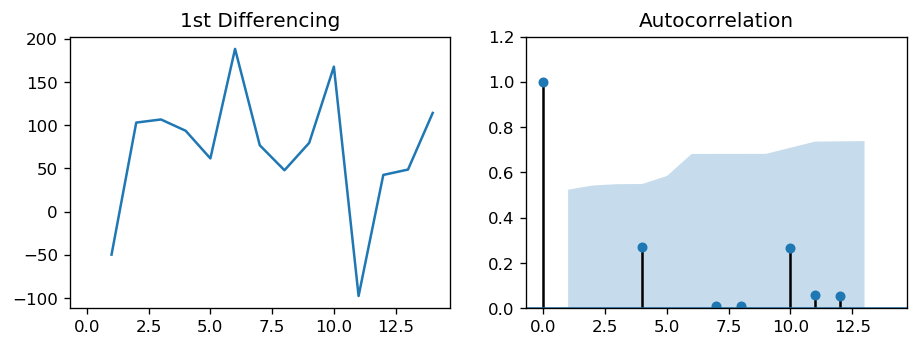

In [31]:
# Order of the MA term (q) for Carbon dioxide 1990-2004 series.

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data[:15].Carbon_dioxide.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(US_gas_data[:15].Carbon_dioxide.diff().dropna(), ax=axes[1])

plt.show()

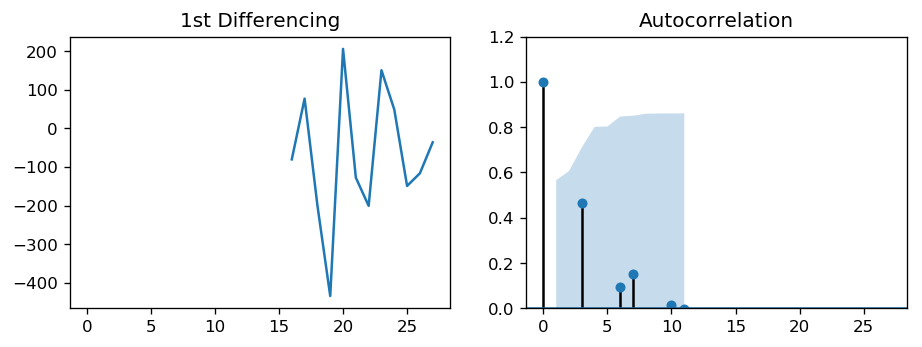

In [32]:
# Order of the MA term (q) for Carbon dioxide 2004-2017 series.

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data[15:].Carbon_dioxide.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(US_gas_data[15:].Carbon_dioxide.diff().dropna(), ax=axes[1])

plt.show()

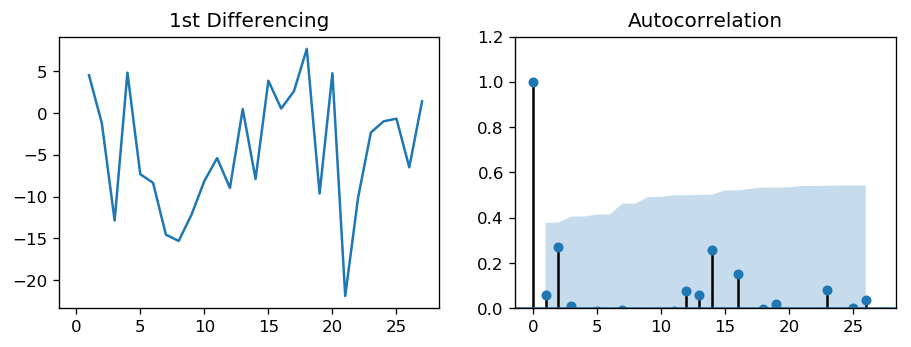

In [33]:
# Order of the MA term (q) for Methane series.

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data.Methane.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(US_gas_data.Methane.diff().dropna(), ax=axes[1])

plt.show()

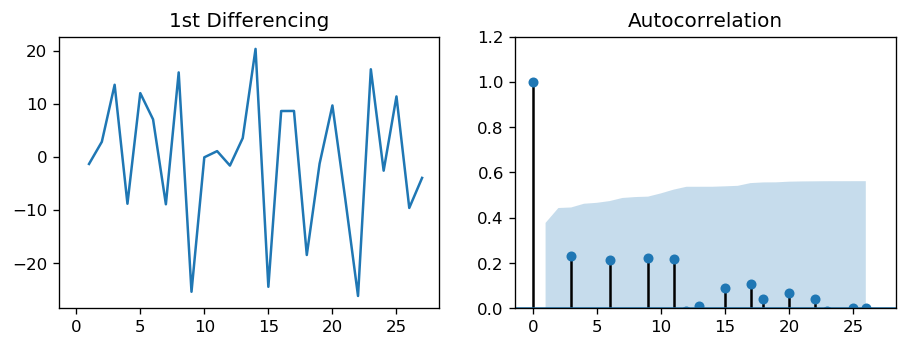

In [34]:
# Order of the MA term (q) for Nitrous_oxide series.

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data.Nitrous_oxide.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(US_gas_data.Nitrous_oxide.diff().dropna(), ax=axes[1])

plt.show()

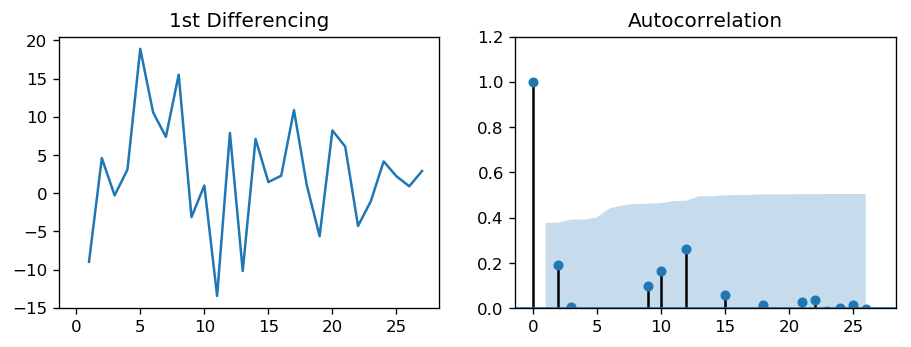

In [35]:
# Order of the MA term (q) for Fluorinated gases series.

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data.Fluorinated_gases.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(US_gas_data.Fluorinated_gases.diff().dropna(), ax=axes[1])

plt.show()

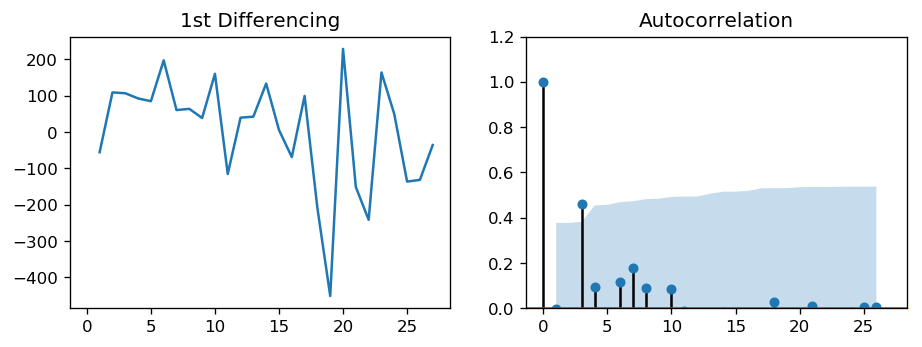

In [36]:
# Order of the MA term (q) for Total gases series.

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(US_gas_data.Total.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(US_gas_data.Total.diff().dropna(), ax=axes[1])

plt.show()

In [37]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,1 (p, d, q) ARIMA Model for Carbon dioxide 1990-2005 series
CO2_uptrend_model = ARIMA(US_gas_data[0:16].Carbon_dioxide, order=(1,1,1))
CO2_uptrend_model_fit = CO2_uptrend_model.fit(disp=0)
print(CO2_uptrend_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.Carbon_dioxide   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -84.134
Method:                       css-mle   S.D. of innovations             62.744
Date:                Thu, 01 Aug 2019   AIC                            176.267
Time:                        20:21:27   BIC                            179.099
Sample:                             1   HQIC                           176.237
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     71.5274      7.026     10.180      0.000      57.757      85.298
ar.L1.D.Carbon_dioxide     0.6111      0.244      2.501      0.028       0.132       1.090
ma.L

Interpretation: The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms. The coef for the MA1 term for the uptrend of Carbon_dioxide is close to zero (-0.9998). The P-value is also << 0.05 (0.00) thus the respective X is highly significant.

Next, potting the residuals ensures that there are no patterns (that is, look for constant mean and variance).

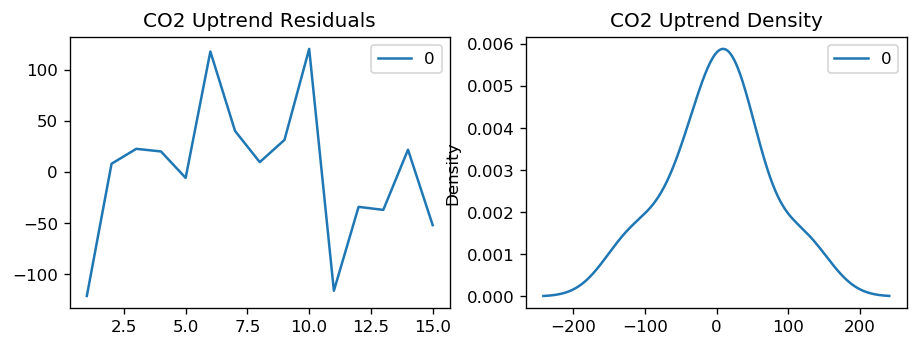

In [38]:
# Plot residual errors for Carbon dioxide 1990-2005 series
CO2_uptrend_residuals = pd.DataFrame(CO2_uptrend_model_fit.resid)
fig, ax = plt.subplots(1,2)
CO2_uptrend_residuals.plot(title="CO2 Uptrend Residuals", ax=ax[0])
CO2_uptrend_residuals.plot(kind='kde', title='CO2 Uptrend Density', ax=ax[1])
plt.show()

The residual errors for the Carbon dioxide 1990-2005 series should show near zero mean (left graph) and uniform variance (right graph).

Next, we plot the actual against the fitted values for Carbon dioxide 1990-2005 series using plot_predict().

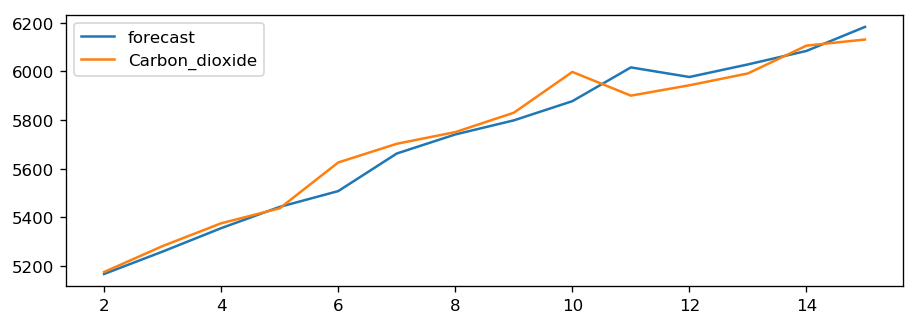

In [39]:
# Actual vs Fitted for Carbon dioxide 1990-2005 series
CO2_uptrend_model_fit.plot_predict(dynamic=False)
plt.show()

Setting dynamic as False means that the in-sample lagged values are used for prediction. In other words, the model gets trained up until the previous value to make the next prediction.

In [40]:
# 1,1,1 (p, d, q) ARIMA Model for Carbon dioxide 2004-2017 series
CO2_downtrend_model = ARIMA(US_gas_data[15:].Carbon_dioxide, order=(1,1,1))
CO2_downtrend_model_fit = CO2_downtrend_model.fit(disp=0)
print(CO2_downtrend_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.Carbon_dioxide   No. Observations:                   12
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -76.521
Method:                       css-mle   S.D. of innovations            130.407
Date:                Thu, 01 Aug 2019   AIC                            161.043
Time:                        20:21:39   BIC                            162.982
Sample:                             1   HQIC                           160.325
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -71.6261     12.031     -5.953      0.000     -95.207     -48.046
ar.L1.D.Carbon_dioxide     0.2562      0.294      0.872      0.406      -0.320       0.832
ma.L

Interpretation: The coef for the MA1 term for the downtrend of Carbon_dioxide is close to zero (-1.0000). The P-value is also << 0.05 (0.004) thus the respective X is highly significant.

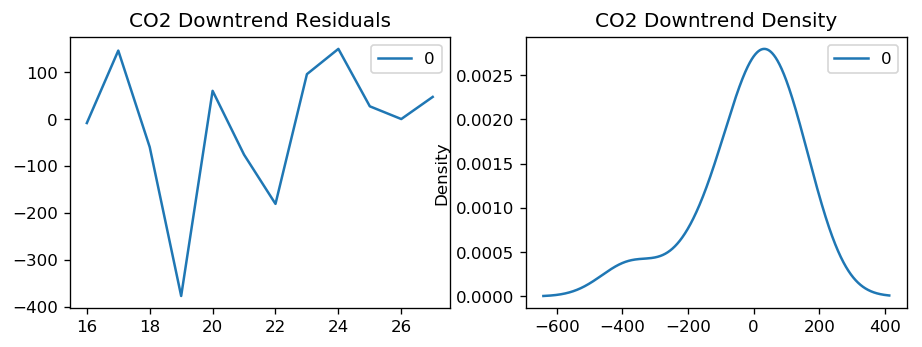

In [41]:
# Plot residual errors for Carbon dioxide 2004-2017 series
CO2_downtrend_residuals = pd.DataFrame(CO2_downtrend_model_fit.resid)
fig, ax = plt.subplots(1,2)
CO2_downtrend_residuals.plot(title="CO2 Downtrend Residuals", ax=ax[0])
CO2_downtrend_residuals.plot(kind='kde', title='CO2 Downtrend Density', ax=ax[1])
plt.show()

ValueError: Length of passed values is 5, index implies 1

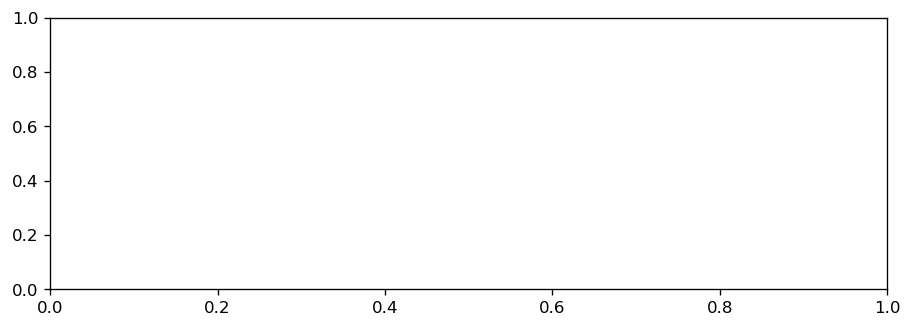

In [42]:
# Actual vs Fitted for Carbon dioxide 2004-2017 series
CO2_downtrend_model_fit.plot_predict(dynamic=False)
plt.show()

In [43]:
# 1,1,1 (p, d, q) ARIMA Model for Methane series
methane_model = ARIMA(US_gas_data.Methane.diff().dropna(), order=(1,1,1))
methane_model_fit = methane_model.fit(disp=0)
print(methane_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.Methane   No. Observations:                   26
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -90.448
Method:                       css-mle   S.D. of innovations              7.768
Date:                Thu, 01 Aug 2019   AIC                            188.896
Time:                        20:22:05   BIC                            193.928
Sample:                             1   HQIC                           190.345
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0977      0.796     -0.123      0.903      -1.657       1.462
ar.L1.D.Methane    -0.4366      0.313     -1.395      0.176      -1.050       0.177
ma.L1.D.Methane    -0.2729      

/Users/annieylai/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/annieylai/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [44]:
# 2,1,2 (p, d, q) ARIMA Model for Methane series
methane_model = ARIMA(US_gas_data.Methane, order=(2,1,2))
methane_model_fit = methane_model.fit(disp=0)
print(methane_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.Methane   No. Observations:                   27
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -90.248
Method:                       css-mle   S.D. of innovations              6.468
Date:                Thu, 01 Aug 2019   AIC                            192.497
Time:                        20:22:06   BIC                            200.272
Sample:                             1   HQIC                           194.809
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.4174      1.462     -3.022      0.006      -7.282      -1.552
ar.L1.D.Methane    -1.0115      0.250     -4.046      0.001      -1.502      -0.522
ar.L2.D.Methane    -0.6329      

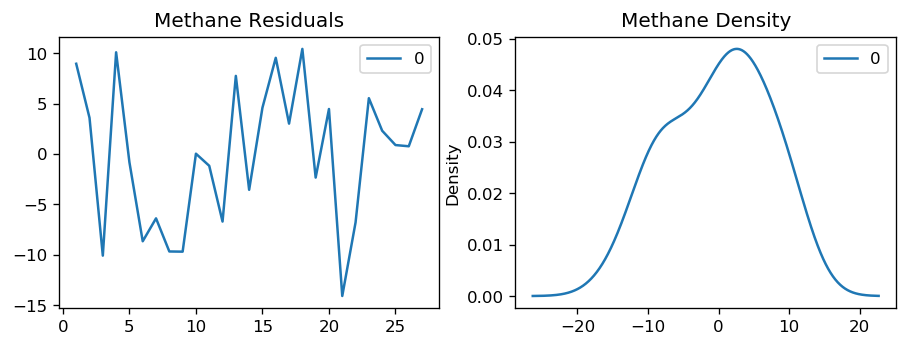

In [45]:
# Plot residual errors for Methane series
methane_residuals = pd.DataFrame(methane_model_fit.resid)
fig, ax = plt.subplots(1,2)
methane_residuals.plot(title="Methane Residuals", ax=ax[0])
methane_residuals.plot(kind='kde', title='Methane Density', ax=ax[1])
plt.show()

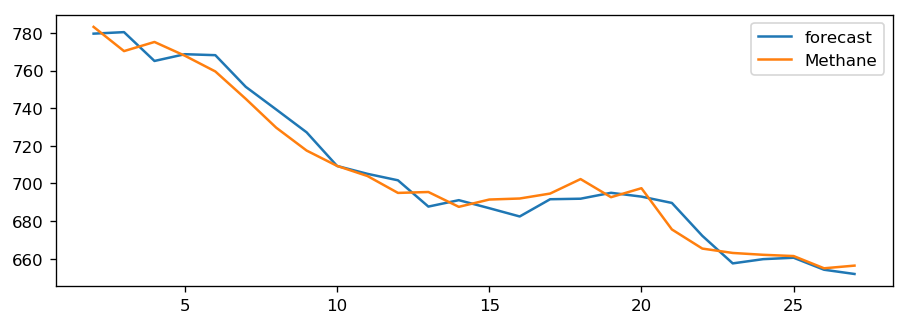

In [46]:
# Actual vs Fitted for methane series
methane_model_fit.plot_predict(dynamic=False)
plt.show()

In [47]:
# 1,1,1 (p, d, q) ARIMA Model for Nitrous_oxide series
Nitrous_oxide_model = ARIMA(US_gas_data.Nitrous_oxide, order=(1,1,1))
Nitrous_oxide_model_fit = Nitrous_oxide_model.fit(disp=0)
print(Nitrous_oxide_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.Nitrous_oxide   No. Observations:                   27
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -102.798
Method:                       css-mle   S.D. of innovations             10.808
Date:                Thu, 01 Aug 2019   AIC                            213.595
Time:                        20:22:15   BIC                            218.779
Sample:                             1   HQIC                           215.136
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.3761      0.911     -0.413      0.683      -2.161       1.409
ar.L1.D.Nitrous_oxide     0.0106      0.415      0.026      0.980      -0.803       0.824
ma.L1.D.

In [48]:
# 2,1,1 (p, d, q) ARIMA Model for Nitrous_oxide series
Nitrous_oxide_model = ARIMA(US_gas_data.Nitrous_oxide, order=(2,1,1))
Nitrous_oxide_model_fit = Nitrous_oxide_model.fit(disp=0)
print(Nitrous_oxide_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.Nitrous_oxide   No. Observations:                   27
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -102.377
Method:                       css-mle   S.D. of innovations             10.639
Date:                Thu, 01 Aug 2019   AIC                            214.755
Time:                        20:22:16   BIC                            221.234
Sample:                             1   HQIC                           216.681
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.2275      1.134     -0.201      0.843      -2.451       1.995
ar.L1.D.Nitrous_oxide    -0.6676      0.449     -1.486      0.151      -1.549       0.213
ar.L2.D.

In [49]:
# 2,1,2 (p, d, q) ARIMA Model for Nitrous_oxide series
Nitrous_oxide_model = ARIMA(US_gas_data.Nitrous_oxide, order=(2,1,2))
Nitrous_oxide_model_fit = Nitrous_oxide_model.fit(disp=0)
print(Nitrous_oxide_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.Nitrous_oxide   No. Observations:                   27
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -102.338
Method:                       css-mle   S.D. of innovations             10.621
Date:                Thu, 01 Aug 2019   AIC                            216.677
Time:                        20:22:18   BIC                            224.452
Sample:                             1   HQIC                           218.989
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.2186      1.218     -0.180      0.859      -2.605       2.168
ar.L1.D.Nitrous_oxide    -0.6385      0.473     -1.351      0.190      -1.565       0.288
ar.L2.D.

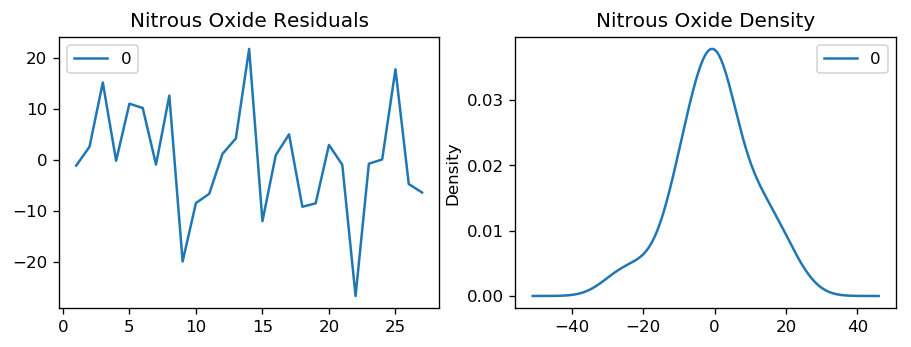

In [50]:
# Plot residual errors for Nitrous_oxide series
Nitrous_oxide_residuals = pd.DataFrame(Nitrous_oxide_model_fit.resid)
fig, ax = plt.subplots(1,2)
Nitrous_oxide_residuals.plot(title="Nitrous Oxide Residuals", ax=ax[0])
Nitrous_oxide_residuals.plot(kind='kde', title='Nitrous Oxide Density', ax=ax[1])
plt.show()

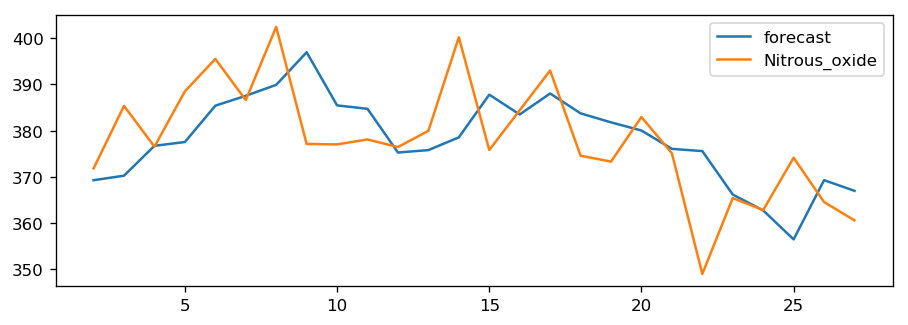

In [51]:
# Actual vs Fitted for Nitrous_oxide series
Nitrous_oxide_model_fit.plot_predict(dynamic=False)
plt.show()

In [53]:
# 2,1,1 (p, d, q) ARIMA Model for Fluorinated_gases series
Fluorinated_gases_model = ARIMA(US_gas_data.Fluorinated_gases, order=(2,1,1))
Fluorinated_gases_model_fit = Fluorinated_gases_model.fit(disp=0)
print(Fluorinated_gases_model_fit.summary())

                              ARIMA Model Results                              
Dep. Variable:     D.Fluorinated_gases   No. Observations:                   27
Model:                  ARIMA(2, 1, 1)   Log Likelihood                 -91.234
Method:                        css-mle   S.D. of innovations              7.089
Date:                 Thu, 01 Aug 2019   AIC                            192.468
Time:                         20:22:36   BIC                            198.947
Sample:                              1   HQIC                           194.395
                                                                               
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.5037      1.590      1.574      0.129      -0.614       5.621
ar.L1.D.Fluorinated_gases    -0.0172      0.541     -0.032      0.975      -1.

In [54]:
# 2,1,2 (p, d, q) ARIMA Model for Fluorinated_gases series
Fluorinated_gases_model = ARIMA(US_gas_data.Fluorinated_gases, order=(2,1,2))
Fluorinated_gases_model_fit = Fluorinated_gases_model.fit(disp=0)
print(Fluorinated_gases_model_fit.summary())

                              ARIMA Model Results                              
Dep. Variable:     D.Fluorinated_gases   No. Observations:                   27
Model:                  ARIMA(2, 1, 2)   Log Likelihood                 -88.033
Method:                        css-mle   S.D. of innovations              5.848
Date:                 Thu, 01 Aug 2019   AIC                            188.066
Time:                         20:22:43   BIC                            195.841
Sample:                              1   HQIC                           190.378
                                                                               
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.4909      1.873      1.330      0.197      -1.180       6.162
ar.L1.D.Fluorinated_gases     0.7309      0.266      2.743      0.012       0.

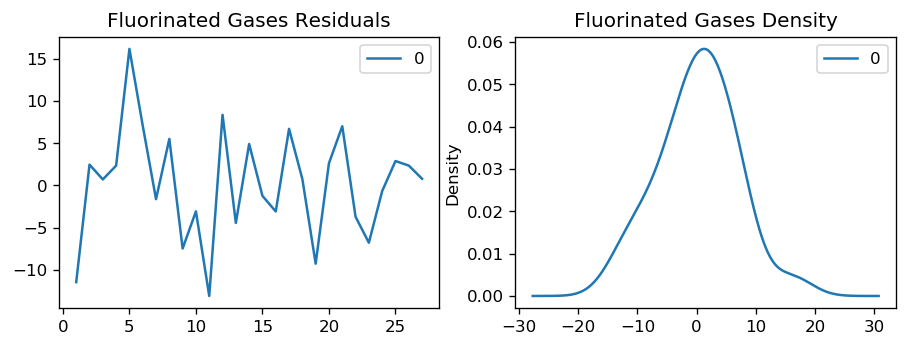

In [55]:
# Plot residual errors for Fluorinated_gases series
Fluorinated_gases_residuals = pd.DataFrame(Fluorinated_gases_model_fit.resid)
fig, ax = plt.subplots(1,2)
Fluorinated_gases_residuals.plot(title="Fluorinated Gases Residuals", ax=ax[0])
Fluorinated_gases_residuals.plot(kind='kde', title='Fluorinated Gases Density', ax=ax[1])
plt.show()

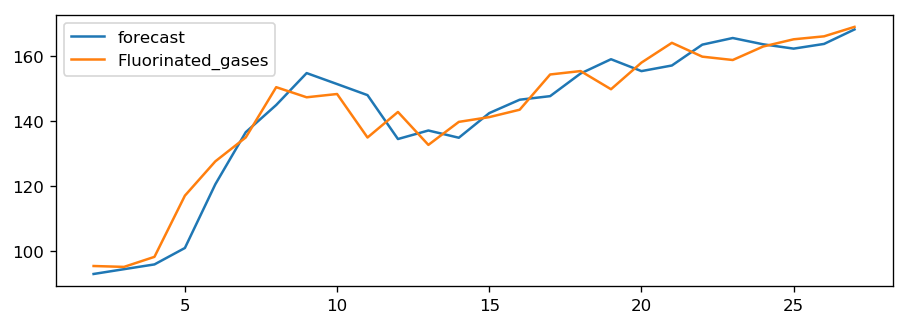

In [56]:
# Actual vs Fitted for Fluorinated_gases series
Fluorinated_gases_model_fit.plot_predict(dynamic=False)
plt.show()

In [57]:
# 1,1,1 (p, d, q) ARIMA Model for Total series
total_model = ARIMA(US_gas_data.Total.diff().dropna(), order=(1,1,1))
total_model_fit = total_model.fit(disp=0)
print(total_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Total   No. Observations:                   26
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -166.753
Method:                       css-mle   S.D. of innovations            137.563
Date:                Thu, 01 Aug 2019   AIC                            341.506
Time:                        20:22:55   BIC                            346.538
Sample:                             1   HQIC                           342.955
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -7.9826      2.920     -2.734      0.012     -13.706      -2.259
ar.L1.D.Total    -0.1901      0.197     -0.966      0.344      -0.576       0.196
ma.L1.D.Total    -1.0000      0.110     

/Users/annieylai/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/annieylai/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


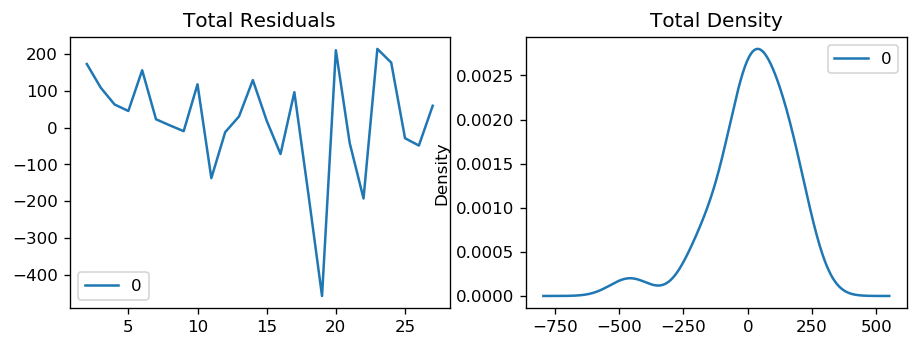

In [58]:
# Plot residual errors for Total series
total_residuals = pd.DataFrame(total_model_fit.resid)
fig, ax = plt.subplots(1,2)
total_residuals.plot(title="Total Residuals", ax=ax[0])
total_residuals.plot(kind='kde', title='Total Density', ax=ax[1])
plt.show()

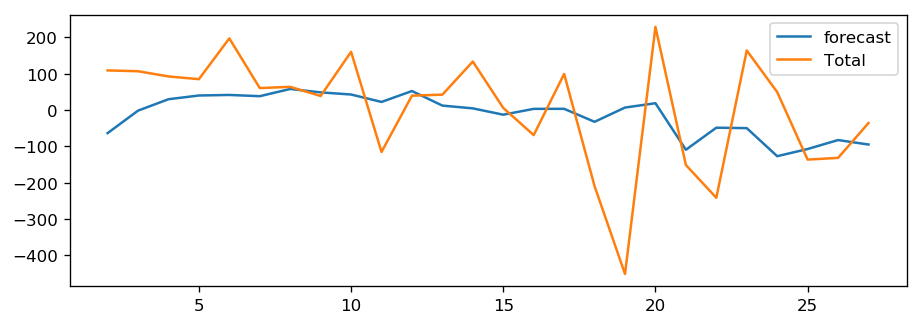

In [59]:
# Actual vs Fitted for Total series
total_model_fit.plot_predict(dynamic=False)
plt.show()

In [60]:
from statsmodels.tsa.stattools import acf

# Create Training and Test (75:25 ratio) for Carbon dioxide 1990-2005 series
CO2_uptrend_train = US_gas_data[:16].Carbon_dioxide[:12]
CO2_uptrend_test = US_gas_data[:16].Carbon_dioxide[12:]

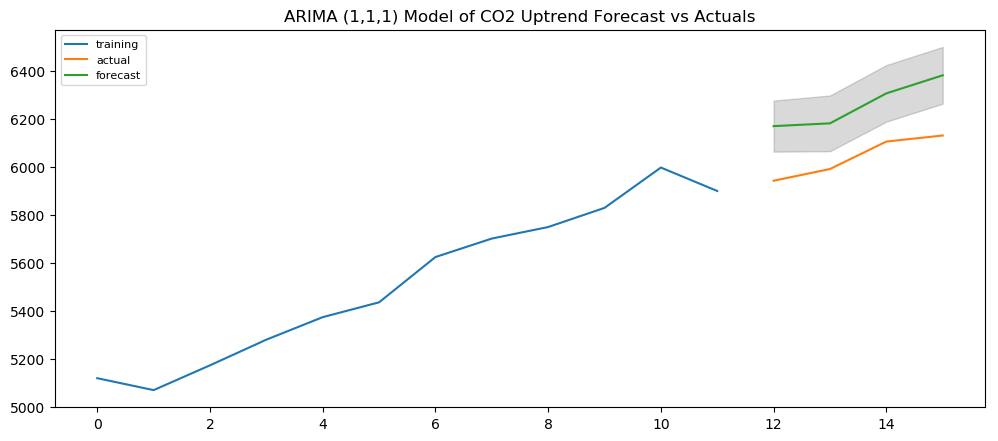

In [61]:
# Build Model for Carbon dioxide 1990-2005 series
# model = ARIMA(train, order=(1,1,1))  
CO2_uptrend_model = ARIMA(CO2_uptrend_train, order=(1, 1, 1))  
CO2_uptrend_fitted = CO2_uptrend_model.fit(disp=-1)  

# Forecast
fc, se, conf = CO2_uptrend_fitted.forecast(4, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=CO2_uptrend_test.index)
lower_series = pd.Series(conf[:, 0], index=CO2_uptrend_test.index)
upper_series = pd.Series(conf[:, 1], index=CO2_uptrend_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(CO2_uptrend_train, label='training')
plt.plot(CO2_uptrend_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('ARIMA (1,1,1) Model of CO2 Uptrend Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [62]:
# Adjust parameters to get the least AIC for Carbon dioxide 1990-2005 series

# 1,1,1 (p, d, q) ARIMA Model for Carbon dioxide 1990-2005 series
model = ARIMA(US_gas_data[:16].Carbon_dioxide, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.Carbon_dioxide   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -84.134
Method:                       css-mle   S.D. of innovations             62.744
Date:                Thu, 01 Aug 2019   AIC                            176.267
Time:                        20:23:06   BIC                            179.099
Sample:                             1   HQIC                           176.237
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     71.5274      7.026     10.180      0.000      57.757      85.298
ar.L1.D.Carbon_dioxide     0.6111      0.244      2.501      0.028       0.132       1.090
ma.L

In [63]:
# 1,1,0 (p, d, q) ARIMA Model for Carbon dioxide 1990-2005 series
adj_CO2_uptrend_model = ARIMA(US_gas_data[:16].Carbon_dioxide, order=(1,1,0))
adj_CO2_uptrend_model_fit = adj_CO2_uptrend_model.fit(disp=0)
print(adj_CO2_uptrend_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.Carbon_dioxide   No. Observations:                   15
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -84.735
Method:                       css-mle   S.D. of innovations             68.578
Date:                Thu, 01 Aug 2019   AIC                            175.471
Time:                        20:23:08   BIC                            177.595
Sample:                             1   HQIC                           175.448
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     69.4525     14.519      4.783      0.000      40.995      97.910
ar.L1.D.Carbon_dioxide    -0.2474      0.273     -0.906      0.381      -0.783       0.288
    

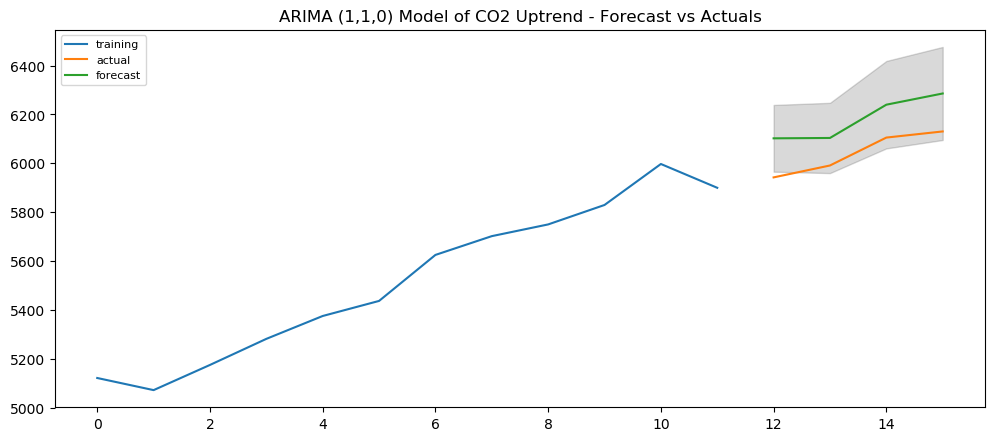

In [64]:
# Build Model for Carbon dioxide 1990-2005 series
# model = ARIMA(train, order=(1,1,0))  
adj_CO2_uptrend_model = ARIMA(CO2_uptrend_train, order=(1, 1, 0))  
adj_CO2_uptrend_fitted = adj_CO2_uptrend_model.fit(disp=-1)  

# Forecast
fc, se, conf = adj_CO2_uptrend_fitted.forecast(4, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=CO2_uptrend_test.index)
lower_series = pd.Series(conf[:, 0], index=CO2_uptrend_test.index)
upper_series = pd.Series(conf[:, 1], index=CO2_uptrend_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(CO2_uptrend_train, label='training')
plt.plot(CO2_uptrend_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('ARIMA (1,1,0) Model of CO2 Uptrend - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [65]:
# Accuracy metrics for Carbon dioxide 1990-2005 series
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-CO2_uptrend_test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, CO2_uptrend_test.values)

{'mape': 0.023279279182733644,
 'me': 140.65542783340038,
 'mae': 140.65542783340038,
 'mpe': 0.023279279182733644,
 'rmse': 141.9034551677156,
 'acf1': -0.32616109276295585,
 'corr': 0.9732936861907149,
 'minmax': 0.022740559591294396}

Around 2.3% MAPE implies the model is about 97.7% accurate in predicting the next 4 observations.

In [66]:
# Create Training and Test (75:25 ratio) for Carbon dioxide 2004-2017 series
CO2_downtrend_train = US_gas_data[13:].Carbon_dioxide[:23]
CO2_downtrend_test = US_gas_data[13:].Carbon_dioxide[23:]

In [76]:
# Build Model for Carbon dioxide 2004-2017 series
# model = ARIMA(train, order=(1,1,1))  
CO2_downtrend_model = ARIMA(CO2_downtrend_train, order=(1, 2, 2))  
CO2_downtrend_fitted = CO2_downtrend_model.fit(disp=-1)

# Forecast
fc, se, conf = CO2_downtrend_fitted.forecast(4, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=CO2_downtrend_test.index)
lower_series = pd.Series(conf[:, 0], index=CO2_downtrend_test.index)
upper_series = pd.Series(conf[:, 1], index=CO2_downtrend_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(CO2_downtrend_train, label='training')
plt.plot(CO2_downtrend_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('ARIMA (2,2,2) Model of CO2 Downtrend Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

ValueError: Length of passed values is 4, index implies 0

In [77]:
# Accuracy metrics for Carbon dioxide 2004-2017 series
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-CO2_downtrend_test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, CO2_downtrend_test.values)

ValueError: operands could not be broadcast together with shapes (4,) (0,) 

Around 3.3% MAPE implies the model is about 96.7% accurate in predicting the next 4 observations.

In [78]:
# Create Training and Test (75:25 ratio) for Methane series
methane_train = US_gas_data.Methane[:21]
methane_test = US_gas_data.Methane[21:]

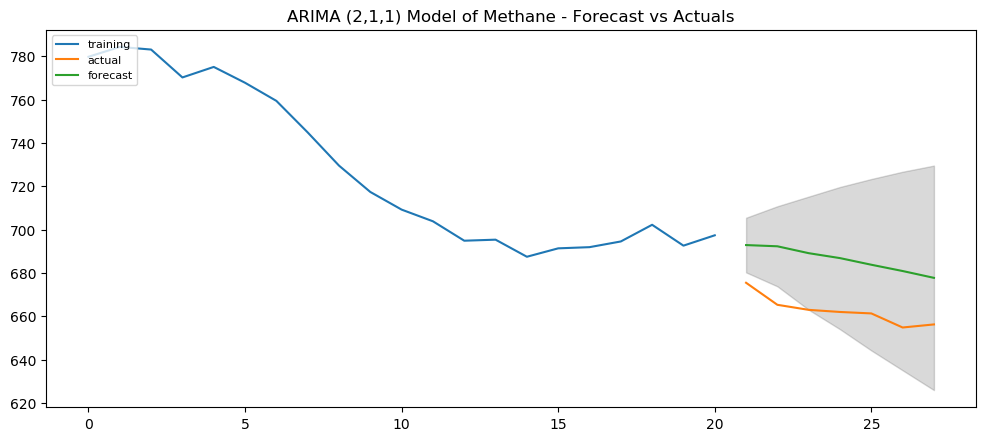

In [79]:
# Build Model for Methane series
# model = ARIMA(train, order=(1,1,1))  
methane_model = ARIMA(methane_train, order=(2, 1, 1))  
methane_fitted = methane_model.fit(disp=-1)  

# Forecast
fc, se, conf = methane_fitted.forecast(7, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=methane_test.index)
lower_series = pd.Series(conf[:, 0], index=methane_test.index)
upper_series = pd.Series(conf[:, 1], index=methane_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(methane_train, label='training')
plt.plot(methane_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('ARIMA (2,1,1) Model of Methane - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [80]:
# Accuracy metrics for Methane series
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-methane_test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, methane_test.values)

{'mape': 0.035693246354333186,
 'me': 23.634635089115267,
 'mae': 23.634635089115267,
 'mpe': 0.035693246354333186,
 'rmse': 23.845157084994565,
 'acf1': -0.27025341186608665,
 'corr': 0.8642261120484014,
 'minmax': 0.034441343797551816}

Around 3.6% MAPE implies the model is about 96.4% accurate in predicting the next 7 observations.

In [81]:
# Create Training and Test (75:25 ratio) for Nitrous_oxide series
Nitrous_oxide_train = US_gas_data.Nitrous_oxide[:21]
Nitrous_oxide_test = US_gas_data.Nitrous_oxide[21:]

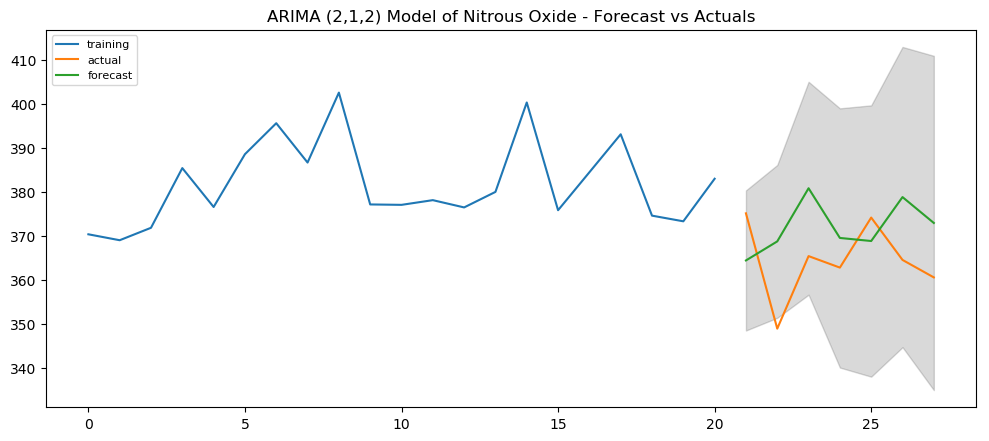

In [82]:
# Build Model for Nitrous_oxide series
# model = ARIMA(train, order=(1,1,1))  
Nitrous_oxide_model = ARIMA(Nitrous_oxide_train, order=(2, 1, 2))  
Nitrous_oxide_fitted = Nitrous_oxide_model.fit(disp=-1)  

# Forecast
fc, se, conf = Nitrous_oxide_fitted.forecast(7, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=Nitrous_oxide_test.index)
lower_series = pd.Series(conf[:, 0], index=Nitrous_oxide_test.index)
upper_series = pd.Series(conf[:, 1], index=Nitrous_oxide_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(Nitrous_oxide_train, label='training')
plt.plot(Nitrous_oxide_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('ARIMA (2,1,2) Model of Nitrous Oxide - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [83]:
# Accuracy metrics for Nitrous_oxide series
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-Nitrous_oxide_test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, Nitrous_oxide_test.values)

{'mape': 0.033403200190534804,
 'me': 7.511791959784221,
 'mae': 12.09220706811295,
 'mpe': 0.021180701520007218,
 'rmse': 12.959111283873426,
 'acf1': -0.22694700733798667,
 'corr': -0.1651736891713229,
 'minmax': 0.03230110442533296}

Around 3.3% MAPE implies the model is about 96.7% accurate in predicting the next 7 observations.

In [84]:
# Create Training and Test (75:25 ratio) for Fluorinated_gases series
Fluorinated_gases_train = US_gas_data.Fluorinated_gases[:21]
Fluorinated_gases_test = US_gas_data.Fluorinated_gases[21:]

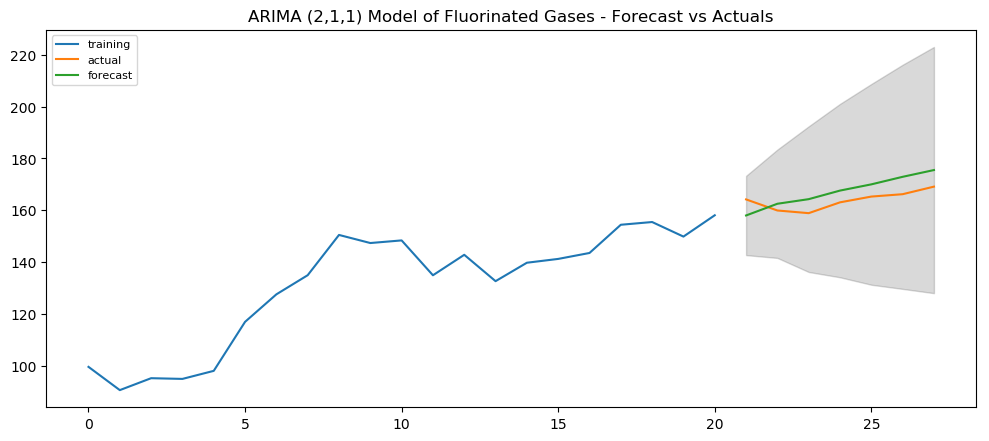

In [85]:
# Build Model for Fluorinated_gases series
# model = ARIMA(train, order=(1,1,1))  
Fluorinated_gases_model = ARIMA(Fluorinated_gases_train, order=(2, 1, 1))  
Fluorinated_gases_fitted = Fluorinated_gases_model.fit(disp=-1)  

# Forecast
fc, se, conf = Fluorinated_gases_fitted.forecast(7, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=Fluorinated_gases_test.index)
lower_series = pd.Series(conf[:, 0], index=Fluorinated_gases_test.index)
upper_series = pd.Series(conf[:, 1], index=Fluorinated_gases_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(Fluorinated_gases_train, label='training')
plt.plot(Fluorinated_gases_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('ARIMA (2,1,1) Model of Fluorinated Gases - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [86]:
# Accuracy metrics for Fluorinated_gases series
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-Fluorinated_gases_test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, Fluorinated_gases_test.values)

{'mape': 0.03175040704435237,
 'me': 3.4471270656879938,
 'mae': 5.216336051932834,
 'mpe': 0.02097670661330434,
 'rmse': 5.380387010077312,
 'acf1': 0.19855630037128014,
 'corr': 0.6928058326511576,
 'minmax': 0.03091440560776948}

Around 3.2% MAPE implies the model is about 96.8% accurate in predicting the next 7 observations.

In [87]:
# Create Training and Test (75:25 ratio) 
total_train = US_gas_data.Total[:21]
total_test = US_gas_data.Total[21:]

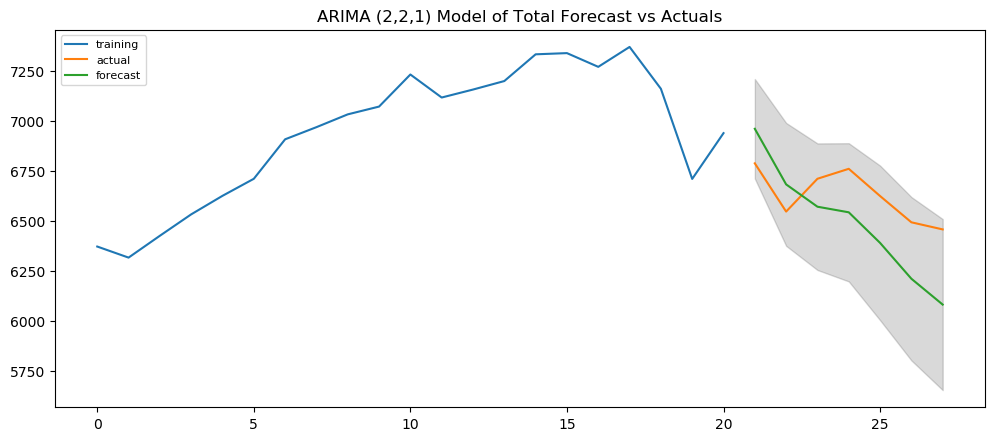

In [88]:
# Build Model for Total series
# model = ARIMA(train, order=(3,2,1))  
total_model = ARIMA(total_train, order=(2, 2, 1))  
total_fitted = total_model.fit(disp=-1)  

# Forecast
fc, se, conf = total_fitted.forecast(7, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=total_test.index)
lower_series = pd.Series(conf[:, 0], index=total_test.index)
upper_series = pd.Series(conf[:, 1], index=total_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(total_train, label='training')
plt.plot(total_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('ARIMA (2,2,1) Model of Total Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [89]:
# Accuracy metrics for Total Series
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-total_test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, total_test.values)

{'mape': 0.03378449404921876,
 'me': -134.54128695166114,
 'mae': 222.82121764384777,
 'mpe': -0.020566745327929743,
 'rmse': 236.55221531816153,
 'acf1': 0.5322905974723626,
 'corr': 0.7768971912118868,
 'minmax': 0.03363362247949464}

Around 3.4% MAPE implies the model is about 96.6% accurate in predicting the next 7 observations.